# Exploratory Data Analysis

### Basic Setting

In [5]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from forecaster.plot import create_scatter_plot_matrix, create_bar_plot
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


warnings.filterwarnings("ignore")


## Problem Statement
- ML problem: predict the GMV

    $$y = f(x_1, \dots, x_p) + \epsilon$$
    - $y$: gmv
    - $x_1, \dots, x_p$: $p$ features, e.g.,
        - Original: `Value of the order in GBP`, `Number of items in the order`, `Country`, `City`, `Type of food`
        - Extended: `day of week`, `event hour`
    - $\epsilon$: noise
    - $f$: unknown function
        - i.e., this is a regresion problem

### Outline
- Raw Data Preparation
- Exploratory Data Analysis
- Modeling
- Furture work


## Raw Data Preparation

### Data loading

In [6]:
users_pdf = pd.read_csv("../data/users.csv").rename({"id": "user_id"}, axis=1)
trasactions_pdf = pd.read_csv("../data/transactions.csv", parse_dates=["event_occurrence"])
stores_pdf = pd.read_csv("../data/stores.csv").rename({"id": "store_id"}, axis=1)

print(f"Users -\n columns: {list(users_pdf.columns)};\n shape: {users_pdf.shape}")
print(
    f"Transactions -\n columns: {list(trasactions_pdf.columns)};\n shape: {trasactions_pdf.shape}"
)
print(f"Stores -\n columns: {list(stores_pdf.columns)};\n shape: {stores_pdf.shape}")


Users -
 columns: ['user_id', 'gender', 'age'];
 shape: (9961, 3)
Transactions -
 columns: ['id', 'user_id', 'store_id', 'event_occurrence', 'amount'];
 shape: (1582260, 5)
Stores -
 columns: ['store_id', 'nam', 'laa', 'category', 'lat', 'lon'];
 shape: (99991, 6)


In [7]:
# pre-condition
assert users_pdf.user_id.is_unique, f"There are duplicate user ids; please check"
assert trasactions_pdf.id.is_unique, f"There are duplicate transaction ids; please check"
assert stores_pdf.store_id.is_unique, f"There are duplicate store ids; please check"

added_user_to_transactions_pdf = pd.merge(trasactions_pdf, users_pdf, on=["user_id"], how="left")
user_store_transactions_pdf = pd.merge(
    added_user_to_transactions_pdf, stores_pdf, on=["store_id"], how="left"
)

# post-condition
assert (
    user_store_transactions_pdf.shape[0] == trasactions_pdf.shape[0]
), "Inconsistent row count. Please check the join process"


In [8]:
user_store_transactions_pdf.head(3)


,id,user_id,store_id,event_occurrence,amount,gender,age,nam,laa,category,lat,lon
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,M,88.0,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,M,44.0,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,M,16.0,Hiroshima Ken,Fukuyama Shi,コンビニ,34.642260,133.257595


In [9]:
user_store_transactions_pdf.dtypes


id                          object
user_id                     object
store_id                    object
event_occurrence    datetime64[ns]
amount                       int64
gender                      object
age                        float64
nam                         object
laa                         object
category                    object
lat                        float64
lon                        float64
dtype: object

### Data Column Setting

In [10]:
target_col = "amont"
categorical_cols = ["gender", "nam", "laa", "category"]
numerical_cols = ["age", "lat", "lon"]
time_cols = ["order_acknowledged_at", "order_ready_at"]


### Missing Value Detection
- Conclusion: there are no missing values in the dataframe

In [11]:
user_store_transactions_pdf.isnull().sum()


id                       0
user_id                  0
store_id                 0
event_occurrence         0
amount                   0
gender              160282
age                  76646
nam                      0
laa                      0
category                 0
lat                      0
lon                      0
dtype: int64

### Anomaly Detection
- Check the range and dispersion of three numerical variables
  - must be positive
      - See `min` in summary statistics)
  - Dispersion
      - See `std` in summary statistics
      - See `IQR = Q3(75%) - Q1(25%)` in summary statistics
      - See boxplot

#### Summary Statistics
- There are no absolutely incorrect observations based on the definition of the variables. (i.e., positive numeric)
- For `prep_time_seconds`, its standard deviation is way larger than its mean, i.e.,
    - its mean would not be an appropriate centrality parameter
    - Should find the robust parameter or transformation before modeling

In [12]:
user_store_transactions_pdf.describe()


,event_occurrence,amount,age,lat,lon
count,1582260,1.582260e+06,1.505614e+06,1.582260e+06,1.582260e+06
mean,2021-03-09 20:10:11.647041792,1.703913e+03,5.001282e+01,3.553551e+01,1.370689e+02
min,2020-01-01 06:40:43.323987,2.000000e+00,1.500000e+01,2.435114e+01,1.238093e+02
25%,2020-10-02 14:56:01.994850304,3.320000e+02,3.400000e+01,3.467408e+01,1.353256e+02
50%,2021-04-09 10:58:40.814747136,7.320000e+02,4.900000e+01,3.538779e+01,1.379939e+02
75%,2021-09-06 10:53:09.993888768,1.675000e+03,6.500000e+01,3.586862e+01,1.397033e+02
max,2021-12-31 17:09:49.237044,1.883119e+06,9.000000e+01,4.543397e+01,1.461748e+02
std,NaN,5.361803e+03,1.911783e+01,2.194248e+00,3.368230e+00


#### Skewness of numerical variables
- `prep_time_seconds`'s skewness is the largest
- The distributions of the variables are right-skewed

In [17]:
user_store_transactions_pdf.skew()


TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'skew'

#### Boxplot
- There are some problematic data points for these three variables in the sense of distribution.


IndexError: index 3 is out of bounds for axis 0 with size 3

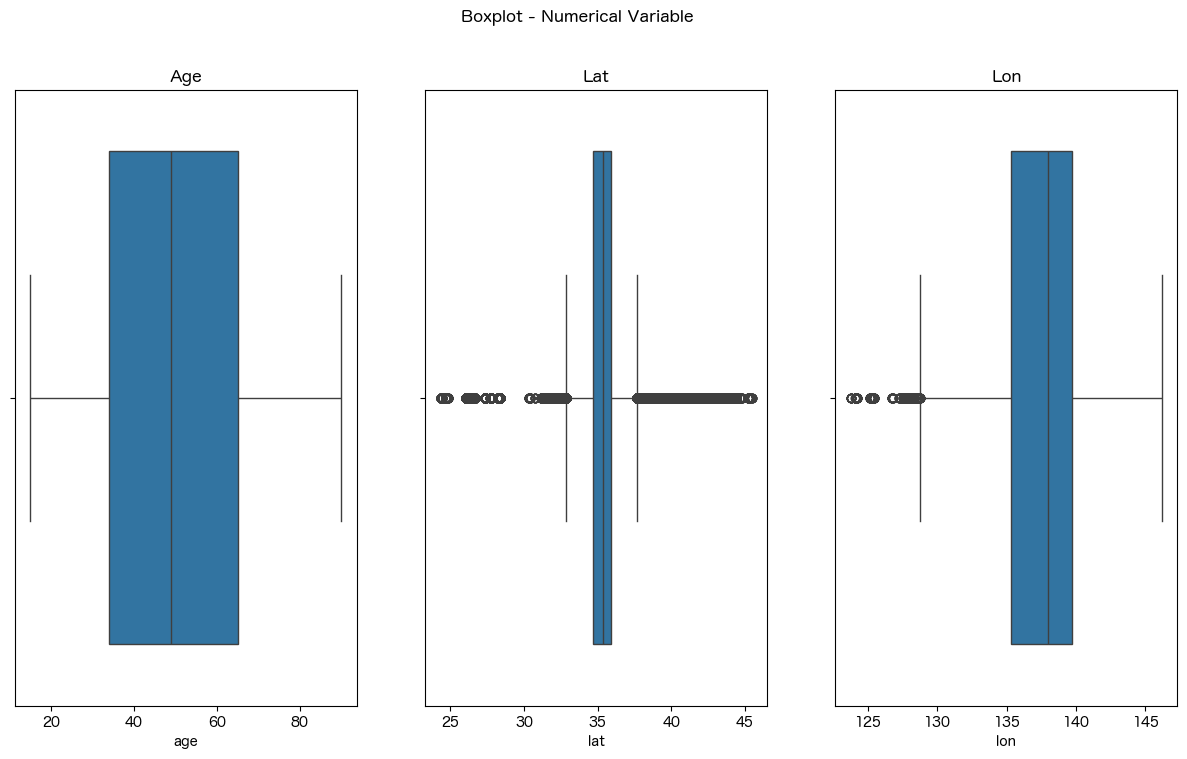

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
fig.suptitle("Boxplot - Numerical Variable")

for idx, column in enumerate(numerical_cols + [target_col]):
    sns.boxplot(ax=axes[idx], x=column, data=user_store_transactions_pdf)
    axes[idx].set_title(column.replace("_", " ").capitalize())


## Exploratory Data Analysis

### Barplot - `Category`
- There are four countries - UK, France, Ireland, Germany
- The left panel shows that the total number of examples in UK is the largest.
- The right panel shows the average preparation times in Ireland and UK are larger than the other two countries
    - The one in UK is larger than the rest of two countries significantly (shorter standard error)

In [ ]:
threshold = int(user_store_transactions_pdf.shape[0] * 0.005)
create_bar_plot(user_store_transactions_pdf, "category", target_col, threshold)


: 

### Barplot -  `City`
- There are 22 cities, but only 9 cities are with enough sample size (shown in the left panel)
    - Assume the threshold is 161 (99.5% examples)
    - The first six cities, except Paris, are in UK.
- In the right panel, regarding of the top nine cities, we can see the preparation time in Paris or Berlin is smaller others.

In [ ]:
plt.figure(figsize=(15, 10))
create_bar_plot(raw_pdf, "city", target_col, threshold)


: 

### Barplot -  `Type of food`
- There are 83 types, but only 30 types are with enough sample size (shown in the left panel)
    - Assume the threshold is 161 (99.5% examples)
    - The first three are `italian`, `burgers`, `thai`
- In the right panel, for the first 30 types, `dessert`'s preparation time is smaller

In [ ]:
plt.figure(figsize=(15, 10))
create_bar_plot(raw_pdf, "type_of_food", target_col, threshold)


: 

### Bivariate Scatter Plot
- The upper diagonal - scatter plot
    - We can see there are few outliers on the three panels
- The diagonal - density plot
    - All three distributions are right-skewed
- The lower diagnoal - 2D density plot
    - It seems like the preparation time is not correlated to `number_of_items` and `order_value_gbp`

In [ ]:
create_scatter_plot_matrix(
    raw_pdf[numerical_cols + categorical_cols + [target_col]], categorical_cols[0]
)


: 

### Association Plot
- Association statistic
    - category-categorty: [Cramer's V](https://en.wikipedia.org/wiki/Cramér%27s_V)
    - category-numeric: [Correlation ratio](https://en.wikipedia.org/wiki/Correlation_ratio)
    - numeric-numeric: Pearson correlation
- Conclusion
    - The association between `country` and `city` is one. It implies that we may only use `country`
    - For the target `pre_time_seconds`, most of asscioation is lower than 1%, instead of the one with `order_value_geb`

In [ ]:
_ = associations(raw_pdf[numerical_cols + categorical_cols + [target_col]], fmt=".1f")


: 

## Feature Engineering
- There are four steps
    1. Transform the target
      - solve the extreme right-skewed and outliers
    2. Combine levels of a categorical variable - type of food
      - solve too many small levels in the category
    3. Create new temporal features
    4. Label-encode categorical features

### Transformation
- Apply the transformation - $\log_{10}(\cdot)$ to `prep_time_seconds`
   

In [ ]:
raw_pdf["transformed_target"] = np.log10(raw_pdf[target_col] + 1e-5)


: 

#### Transformation - Scatter Plot Matrix
- In the upper-diagonal panels, the outliers seems gone after transformation
- The distribution of the new column is more symmetric (this would benefit some traditional regression methods)
- The 2D density plots show that the patterns of countries are more clear than the original ones

In [ ]:
create_scatter_plot_matrix(raw_pdf, categorical_cols[0])
new_target_col = "transformed_target"


: 

#### Transformation - Association Matrix
- The association between the transformed target and other feature is greater than the orignal pattern

In [ ]:
_ = associations(
    raw_pdf[numerical_cols + categorical_cols + [target_col, new_target_col]], fmt=".1f"
)


: 

### Combining Levels of `type of food`
- Based on the previous EDA result, we will combine the levels with lower sample size as a new level `other`.
   - The threshold is supposed to be 161
- The number of the new levels are 31, shown in the panel with the new level `other`

In [ ]:
count_for_type_of_food = raw_pdf["type_of_food"].value_counts()
removed_levels = list(count_for_type_of_food[count_for_type_of_food <= threshold].index)
raw_pdf["type_of_food"] = raw_pdf["type_of_food"].apply(
    lambda x: x if x not in removed_levels else "other"
)


: 

In [ ]:
plt.figure(figsize=(15, 10))
create_bar_plot(raw_pdf, "type_of_food", target_col, threshold)


: 

### New Features
- Heurisic: what if rush hours/weekends will indirectly affect the prepartion time owning to the larger number of orders?
- New feature candidates
    - `acknowledged_hour`: event hour of `order_acknowledged_at`
    - `ready_hour`: event hour of `order_ready_at`
    - `is_weekend_for_order_acknowledged_at`: is weekend for `order_acknowledged_at`
    - `is_weekend_for_order_ready_at`: is weekend for`order_ready_at`
- Conclusion
    - Based on the association matrix, we only pick `ready_hour` and `ready_weekday`

In [ ]:
raw_pdf["acknowledged_hour"] = raw_pdf["order_acknowledged_at"].apply(lambda x: x.hour)
raw_pdf["ready_hour"] = raw_pdf["order_ready_at"].apply(lambda x: x.hour)
raw_pdf["acknowledged_weekday"] = raw_pdf["order_acknowledged_at"].apply(lambda x: x.isoweekday())
raw_pdf["is_weekend_for_order_acknowledged_at"] = raw_pdf["order_acknowledged_at"].apply(
    lambda x: x.dayofweek > 4
)
raw_pdf["is_weekend_for_order_ready_at"] = raw_pdf["order_ready_at"].apply(
    lambda x: x.dayofweek > 4
)


: 

In [ ]:
_ = associations(
    raw_pdf[
        [
            "acknowledged_hour",
            "ready_hour",
            "is_weekend_for_order_acknowledged_at",
            "is_weekend_for_order_ready_at",
        ]
        + [new_target_col]
    ],
    fmt=".1f",
)


: 

### Label Encoding
- We only deal with `country`, `type_of_food`, and `is_weekend_for_order_ready_at`
- This would be used in the lightGBM model.

In [ ]:
categorical_cols.remove("city")
categorical_cols.append("is_weekend_for_order_ready_at")

le = LabelEncoder()

for column in copy.deepcopy(categorical_cols):
    raw_pdf[f"{column}_label"] = le.fit_transform(raw_pdf[column])
    categorical_cols.append(f"{column}_label")
    categorical_cols.remove(column)

raw_pdf[categorical_cols].describe()


: 

### Final features
- Target: `transformed_target`
- Features: `['order_value_gbp', 'number_of_items', 'is_weekend_for_order_ready_at_label', 'ready_hour', 'country_label', 'type_of_food_label']`

In [ ]:
numerical_cols.append("ready_hour")

overall_features = numerical_cols + categorical_cols
_ = associations(raw_pdf[overall_features + [new_target_col]], fmt=".1f")


: 

## Modeling
- Step 1. Training data generation
- Step 2. Train a lightGBM model based on training and validataion datasets
- Step 3. Model evaluation

### Training data generation
- We split data into `training set`, `validation set`, and `testing set` with testing rate and validation rate being 0.2.
- Note
    - The distribution of the target in these three sets are similar.

In [ ]:
testing_rate = 0.2
validation_rate = 0.2
randome_seed = 1234

X_train, X_test, y_train, y_test = train_test_split(
    raw_pdf[overall_features],
    raw_pdf[new_target_col],
    test_size=testing_rate,
    random_state=randome_seed,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=validation_rate, random_state=randome_seed
)

print(f"The number of the training set: {X_train.shape[0]}")
print(f"The number of the validation set: {X_val.shape[0]}")
print(f"The number of the testing set: {X_test.shape[0]}")


: 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle("Distribution of the target in three datasets")
axes[0].set_title(f"Training -  sample size {X_train.shape[0]}")
y_train.hist(ax=axes[0])
axes[1].set_title(f"Validation - sample size {X_val.shape[0]}")
y_val.hist(ax=axes[1])
axes[2].set_title(f"Testing -  sample size {X_test.shape[0]}")
y_test.hist(ax=axes[2])


: 

### Model training
- Model: light GBM
   - can use categorical features directly (without one-hot or label encoding)
- Loss function: mean absolute error $\|y - \hat{y}\|_1$
- [To-Do] Hyperparameter selection: 5-fold CV by `lgb.cv`

In [ ]:
# Generate light GBM datasets
train_lgb = lgb.Dataset(
    data=X_train,
    label=y_train,
    feature_name=list(X_train.columns),
    categorical_feature=categorical_cols,
    free_raw_data=False,
)
val_lgb = lgb.Dataset(
    data=X_val,
    label=y_val,
    feature_name=list(X_val.columns),
    categorical_feature=categorical_cols,
    free_raw_data=False,
)
test_lgb = lgb.Dataset(
    data=X_test,
    label=y_test,
    feature_name=list(X_test.columns),
    categorical_feature=categorical_cols,
    free_raw_data=False,
)


: 

In [ ]:
parameters = {
    "num_leaves": 10,
    "num_trees": 50,
    "objective": "regression",
    "metric": "mae",
}

save_eval_results = {}
model = lgb.train(
    parameters,
    train_lgb,
    valid_sets=[train_lgb, val_lgb],
    valid_names=["train", "validation"],
    evals_result=save_eval_results,
    verbose_eval=5,
)


: 

### Model evaluation
1. Plot validation MAE during training¶
    - The training and validation losses are similar although it's overfitting a bit after the 20th iteration.
2. The testing MAE is 0.29, which is similar to the validation loss. It implies that 

In [ ]:
# Validation
lgb.plot_metric(save_eval_results)

# Test
ypred = model.predict(X_test)
score = metrics.mean_absolute_error(y_test, ypred)
print(f"Test MAE: {score}")


: 

### Feature importance

- The most two important features are `order_value_gdp` and `type_of_food` based on the trained model.
- It is kind of strange that `ready_hour` is the third important feature but with near-zero association with the transformed target vairalbe.
  - There probably exists some hidden correlation among features
  
- This would make sense since the larger order value of a meal may have longer prepration time, especially for fine dining.

In [ ]:
feature_imp = pd.DataFrame({"Importance": model.feature_importance(), "Feature": X_train.columns})
plt.figure(figsize=(16, 8))
sns.set(font_scale=2)
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_imp.sort_values(by="Importance", ascending=False)[0:20],
)
plt.title("LightGBM  Importance")
plt.tight_layout()


: 

### Decision Tree
- Since the trained model includes 50 trees, we can select few of them for marketing stratege
- For example
 1. The first panel:
    - The first split is whether country is UK or not; then follow differnt nodes
 2. The second panel:
    - The root node is to see if the number of items is less than 4.5 or not; then go to the type of food.
    

In [ ]:
lgb.plot_tree(model, tree_index=0, figsize=(64, 36), show_info=["split_gain"])


: 

In [ ]:
lgb.plot_tree(model, tree_index=49, figsize=(64, 36), show_info=["split_gain"])


: 

## Future work


### I. Enlarge data pool
- So far, we only have some pieces of order information and resturant information.
- There are three perspective to enlarge the data pool to gain more informative buisness insight
 1. Resturant semantic meaning
    - Based on the menu and resturarnt description, we can train a model for text embeddings to represent the semantic structure among the resturants.
       - This will mitigate the side effect when the types of food change
 2. Geo-based features
     - weather: rainfall, temperature
     - resturant location
     - city population
 3. Temperoal faetures
     - Since we only have data in June, there will be seasonal effects for the prepration time.
     - We haven't checked the autocorrelation within the time series yet. We may create other hidden temporal dependency features into the model.

### II. Model enhancement
- Model tuning 
    - Use K-fold cross-validation to select the best hyperparameters (e.g. # of trees)
- Model calibration
    - Create another model as a baseline to compete the lightGBM model. It would more easier to see the weakeness of the current model and then have a reliable way to improve it.  
- Residual analysis
    - We haven't exaime the distribution of the residuals. This should be important for validating the model assumptions.

### III. Model serving
- We can save the model by `model.save_model(file_path)` to the object storage (e.g., S3)
- Then, we can serving the model based on the BentoML framework
    - i.e., we can input the features of each order to predict preparation time in short time via restful API

### IV. Causal inference
- From the business perspecitve, having a better model for predicting prepration time do not imply we can make profit from it.
- It would be better to find the real potential causes by the causal inference framework, such as Bayesian network.
    - More specifically, if we would like to reduce preparation time as much as possible, we have to find the real causes for the preparation based on the likelihood.
    - Sometimes, there will be propogation when the order has been delayed in a resturant.